In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install tensorflow-io==0.23.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 23.1 MB 85.0 MB/s 
     |████████████████████████████████| 2.1 MB 51.7 MB/s 
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.26.0
    Uninstalling tensorflow-io-gcs-filesystem-0.26.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.26.0


In [3]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

In [4]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [5]:
testing_wav_file_name = tf.keras.utils.get_file('miaow_16k.wav',
                                                'https://storage.googleapis.com/audioset/miaow_16k.wav',
                                                cache_dir='./',
                                                cache_subdir='test_data')

print(testing_wav_file_name)

229376/215546 [===============================] - 0s 0us/step
./test_data/miaow_16k.wav


In [6]:
# Utility functions for loading audio files and making sure the sample rate is correct.

@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

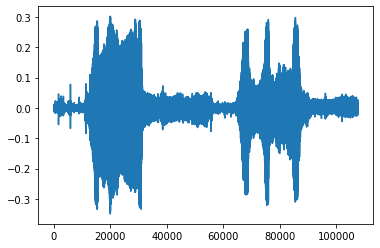

In [7]:
testing_wav_data = load_wav_16k_mono(testing_wav_file_name)

_ = plt.plot(testing_wav_data)

# Play the audio file.
display.Audio(testing_wav_data, rate=16000)

In [8]:
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

for name in class_names[:20]:
  print(name)
print('...')

Speech
Child speech, kid speaking
Conversation
Narration, monologue
Babbling
Speech synthesizer
Shout
Bellow
Whoop
Yell
Children shouting
Screaming
Whispering
Laughter
Baby laughter
Giggle
Snicker
Belly laugh
Chuckle, chortle
Crying, sobbing
...


In [9]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.math.argmax(class_scores)
inferred_class = class_names[top_class]

print(f'The main sound is: {inferred_class}')
print(f'The embeddings shape: {embeddings.shape}')

The main sound is: Animal
The embeddings shape: (13, 1024)


In [9]:
_ = tf.keras.utils.get_file('esc-50.zip',
                        'https://github.com/karoldvl/ESC-50/archive/master.zip',
                        cache_dir='./',
                        cache_subdir='datasets',
                        extract=True)

645701632/Unknown - 50s 0us/step

In [10]:
esc50_csv = './datasets/ESC-50-master/meta/esc50.csv'
base_data_path = './datasets/ESC-50-master/audio/'

pd_data = pd.read_csv(esc50_csv)
pd_data.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [11]:
my_classes = ['dog']
map_class_to_id = {'dog':1}

filtered_pd = pd_data[pd_data.category.isin(my_classes)]

class_id = filtered_pd['category'].apply(lambda name: map_class_to_id[name])
filtered_pd = filtered_pd.assign(target=class_id)

full_path = filtered_pd['filename'].apply(lambda row: os.path.join(base_data_path, row))
filtered_pd = filtered_pd.assign(filename=full_path)

filtered_pd.head(10)

,filename,fold,target,category,esc10,src_file,take
0,./datasets/ESC-50-master/audio/1-100032-A-0.wav,1,1,dog,True,100032,A
14,./datasets/ESC-50-master/audio/1-110389-A-0.wav,1,1,dog,True,110389,A
157,./datasets/ESC-50-master/audio/1-30226-A-0.wav,1,1,dog,True,30226,A
158,./datasets/ESC-50-master/audio/1-30344-A-0.wav,1,1,dog,True,30344,A
170,./datasets/ESC-50-master/audio/1-32318-A-0.wav,1,1,dog,True,32318,A
296,./datasets/ESC-50-master/audio/1-59513-A-0.wav,1,1,dog,True,59513,A
375,./datasets/ESC-50-master/audio/1-85362-A-0.wav,1,1,dog,True,85362,A
392,./datasets/ESC-50-master/audio/1-97392-A-0.wav,1,1,dog,True,97392,A
478,./datasets/ESC-50-master/audio/2-114280-A-0.wav,2,1,dog,True,114280,A
479,./datasets/ESC-50-master/audio/2-114587-A-0.wav,2,1,dog,True,114587,A


In [12]:
filenames = filtered_pd['filename']
targets = filtered_pd['target']
folds = filtered_pd['fold']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [13]:
def load_wav_for_map(filename, label, fold):
  return load_wav_16k_mono(filename), label, fold

main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [14]:
# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, label, fold):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

# extract embedding
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec


(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [25]:
cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold < 4)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 4)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 5)

# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

In [35]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(1024), dtype=tf.float32, name='input_embedding'))
model.add(tf.keras.layers.Dense(50, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [36]:
# my_model = tf.keras.Sequential([
#     tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
#                           name='input_embedding'),
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dense(len(my_classes), activation='sigmoid')
# ], name='my_model')

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 50)                51250     
                                                                 
 dense_11 (Dense)            (None, 1)                 51        
                                                                 
Total params: 51,301
Trainable params: 51,301
Non-trainable params: 0
_________________________________________________________________


In [26]:
my_model.compile(loss='binary_crossentropy',
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)


In [37]:
history = model.fit(train_ds,
                       epochs=20,
                       validation_data=val_ds,
                       callbacks=callback)


Epoch 1/20
8/8 [==============================] - 1s 49ms/step - loss: 0.1276 - accuracy: 1.0000 - val_loss: 0.0258 - val_accuracy: 1.0000
Epoch 2/20
8/8 [==============================] - 0s 32ms/step - loss: 0.0187 - accuracy: 1.0000 - val_loss: 0.0091 - val_accuracy: 1.0000
Epoch 3/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.0054 - val_accuracy: 1.0000
Epoch 4/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 5/20
8/8 [==============================] - 0s 33ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 6/20
8/8 [==============================] - 0s 32ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 7/20
8/8 [==============================] - 0s 32ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 8/20
8/8 [===========

In [38]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)


3/3 [==============================] - 0s 17ms/step - loss: 6.5109e-04 - accuracy: 1.0000
Loss:  0.0006510946550406516
Accuracy:  1.0


In [41]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
result = model(embeddings).numpy()
print(result)
inferred_class = my_classes[result.mean(axis=0).argmax()]
print(f'The main sound is: {inferred_class}')

[[0.98793215]
 [0.9994873 ]
 [0.9989557 ]
 [0.99719703]
 [0.99215204]
 [0.9954621 ]
 [0.9945585 ]
 [0.9919075 ]
 [0.999892  ]
 [0.99994063]
 [0.99909806]
 [0.9992495 ]
 [0.9959533 ]]
The main sound is: dog


In [27]:

import glob
source_path="/content/gdrive/MyDrive/transfer_learn_yamnet_model/dataset/train/sexual"
image_files_train = []
for path in glob.glob(source_path + '/*'):
      image_files_train.append(path)

dfs = pd.DataFrame({'filename': image_files_train })


In [28]:
import glob
source_path="/content/gdrive/MyDrive/transfer_learn_yamnet_model/dataset/train/normal"
image_files_train = []
for path in glob.glob(source_path + '/*'):
      image_files_train.append(path)

dfn = pd.DataFrame({'filename': image_files_train })

In [85]:
dfs = pd.DataFrame({'filename': image_files_train })

In [29]:
dfs['target']=0
dfs['fold']=1
dfs['category']="sexual"
dfs.head()

,filename,target,fold,category
0,/content/gdrive/MyDrive/transfer_learn_yamnet_...,0,1,sexual
1,/content/gdrive/MyDrive/transfer_learn_yamnet_...,0,1,sexual
2,/content/gdrive/MyDrive/transfer_learn_yamnet_...,0,1,sexual
3,/content/gdrive/MyDrive/transfer_learn_yamnet_...,0,1,sexual
4,/content/gdrive/MyDrive/transfer_learn_yamnet_...,0,1,sexual


In [30]:
dfn['target']=1
dfn['fold']=2
dfn['category']="normal"
dfn.head()

,filename,target,fold,category
0,/content/gdrive/MyDrive/transfer_learn_yamnet_...,1,2,normal
1,/content/gdrive/MyDrive/transfer_learn_yamnet_...,1,2,normal
2,/content/gdrive/MyDrive/transfer_learn_yamnet_...,1,2,normal
3,/content/gdrive/MyDrive/transfer_learn_yamnet_...,1,2,normal
4,/content/gdrive/MyDrive/transfer_learn_yamnet_...,1,2,normal


In [31]:
df=pd.concat([dfs,dfn])

In [32]:
df.columns

Index(['filename', 'target', 'fold', 'category'], dtype='object')

In [33]:
df_test=pd.concat([dfs.head(17),dfn.head(17)])
df_train=pd.concat([dfs.tail(70),dfn.tail(70)])
df_val=pd.concat([dfs.tail(10),dfn.tail(10)])

In [26]:
#ufo.loc[0:2, :]
df_test = dfs.loc[0:19,:]
df_train = dfs.loc[19:90,:]
df_val = dfs.loc[91:,:]

KeyError: ignored

In [34]:


# filtered_pd=df.copy()
my_classes = ['sexual', 'normal']
map_class_to_id = {'sexual':0, 'normal':1}

filtered_pd = df[df.category.isin(my_classes)]

class_id = filtered_pd['category'].apply(lambda name: map_class_to_id[name])
filtered_pd = filtered_pd.assign(target=class_id)

# full_path = filtered_pd['filename'].apply(lambda row: os.path.join(base_data_path, row))
# filtered_pd = filtered_pd.assign(filename=full_path)

filtered_pd.tail(10)




,filename,target,fold,category
30,/content/gdrive/MyDrive/transfer_learn_yamnet_...,1,2,normal
31,/content/gdrive/MyDrive/transfer_learn_yamnet_...,1,2,normal
32,/content/gdrive/MyDrive/transfer_learn_yamnet_...,1,2,normal
33,/content/gdrive/MyDrive/transfer_learn_yamnet_...,1,2,normal
34,/content/gdrive/MyDrive/transfer_learn_yamnet_...,1,2,normal
35,/content/gdrive/MyDrive/transfer_learn_yamnet_...,1,2,normal
36,/content/gdrive/MyDrive/transfer_learn_yamnet_...,1,2,normal
37,/content/gdrive/MyDrive/transfer_learn_yamnet_...,1,2,normal
38,/content/gdrive/MyDrive/transfer_learn_yamnet_...,1,2,normal
39,/content/gdrive/MyDrive/transfer_learn_yamnet_...,1,2,normal


In [35]:
filenames = df_train['filename']
targets = df_train['target']
folds = df_train['fold']

main_df_train = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
main_df_train.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [36]:
filenames = df_test['filename']
targets = df_test['target']
folds = df_test['fold']

main_df_test = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
main_df_test.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [37]:
filenames = df_val['filename']
targets = df_val['target']
folds = df_val['fold']

main_df_val = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
main_df_val.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [38]:
def load_wav_for_map(filename, label, fold):
  return load_wav_16k_mono(filename), label, fold

try:
  main_df_train = main_df_train.map(load_wav_for_map)
  main_df_train.element_spec
except:
  pass

main_df_test = main_df_test.map(load_wav_for_map)
main_df_test.element_spec

main_df_val = main_df_val.map(load_wav_for_map)
main_df_val.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [39]:
# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, label, fold):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

# extract embedding
main_df_train = main_df_train.map(extract_embedding).unbatch()
main_df_train.element_spec

main_df_test = main_df_test.map(extract_embedding).unbatch()
main_df_test.element_spec

main_df_val = main_df_val.map(extract_embedding).unbatch()
main_df_val.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [40]:
cached_ds_train = main_df_train.cache()
cached_ds_test = main_df_test.cache()
cached_ds_val = main_df_val.cache()

In [41]:
train_ds = cached_ds_train.filter(lambda embedding, label, fold: fold < 4)
val_ds = cached_ds_val.filter(lambda embedding, label, fold: fold < 4)
test_ds = cached_ds_test.filter(lambda embedding, label, fold: fold < 5)

# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

In [42]:
train_ds = cached_ds_train.filter(lambda embedding, label, fold: fold < 4)
val_ds = cached_ds_val.filter(lambda embedding, label, fold: fold < 4)
test_ds = cached_ds_test.filter(lambda embedding, label, fold: fold < 5)

# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

In [45]:
modelS = tf.keras.Sequential()
modelS.add(tf.keras.layers.Input(shape=(1024), dtype=tf.float32, name='input_embedding'))
modelS.add(tf.keras.layers.Dense(50, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
modelS.add(tf.keras.layers.Dense(2, activation='sigmoid'))
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
modelS.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [46]:
modelS.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 50)                51250     
                                                                 
 dense_3 (Dense)             (None, 2)                 102       
                                                                 
Total params: 51,352
Trainable params: 51,352
Non-trainable params: 0
_________________________________________________________________


In [85]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='softmax'),
    tf.keras.layers.Dense(len(my_classes))
], name='my_model')

my_model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 512)               524800    
                                                                 
 dense_11 (Dense)            (None, 2)                 1026      
                                                                 
Total params: 525,826
Trainable params: 525,826
Non-trainable params: 0
_________________________________________________________________


In [86]:


my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=2,
                                            restore_best_weights=True)



In [87]:


history = my_model.fit(train_ds,
                       epochs=100,
                       validation_data=val_ds,
                       callbacks=callback)



Epoch 1/100
45/45 [==============================] - 1s 10ms/step - loss: 0.6681 - accuracy: 0.7448 - val_loss: 0.6731 - val_accuracy: 0.6111
Epoch 2/100
45/45 [==============================] - 0s 8ms/step - loss: 0.6202 - accuracy: 0.7748 - val_loss: 0.6481 - val_accuracy: 0.6111
Epoch 3/100
45/45 [==============================] - 0s 9ms/step - loss: 0.5638 - accuracy: 0.7755 - val_loss: 0.6022 - val_accuracy: 0.6111
Epoch 4/100
45/45 [==============================] - 1s 12ms/step - loss: 0.5061 - accuracy: 0.7895 - val_loss: 0.5533 - val_accuracy: 0.7650
Epoch 5/100
45/45 [==============================] - 1s 12ms/step - loss: 0.4507 - accuracy: 0.8713 - val_loss: 0.4923 - val_accuracy: 0.8462
Epoch 6/100
45/45 [==============================] - 1s 12ms/step - loss: 0.4040 - accuracy: 0.9098 - val_loss: 0.4457 - val_accuracy: 0.8803
Epoch 7/100
45/45 [==============================] - 0s 8ms/step - loss: 0.3702 - accuracy: 0.9210 - val_loss: 0.4129 - val_accuracy: 0.8932
Epoch 8/1

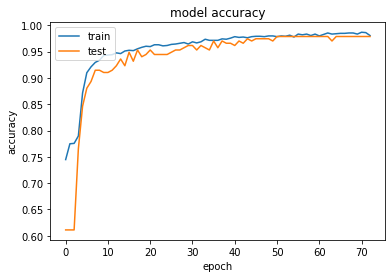

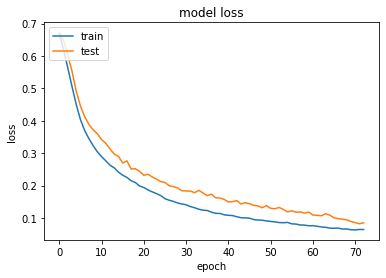

In [88]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [89]:


loss, accuracy = my_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)



13/13 [==============================] - 0s 4ms/step - loss: 0.1013 - accuracy: 0.9694
Loss:  0.10131023079156876
Accuracy:  0.9693877696990967


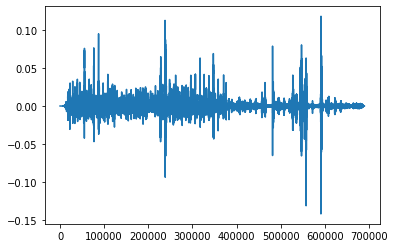

In [90]:
testing_wav_file_name="/content/gdrive/MyDrive/transfer_learn_yamnet_model/test_clip/running.wav"

# testing_wav_data = load_wav_16k_mono(audio_path)

testing_wav_data = load_wav_16k_mono(testing_wav_file_name)

_ = plt.plot(testing_wav_data)

# Play the audio file.
display.Audio(testing_wav_data,rate=16000)

In [80]:
testing_wav_data.shape

TensorShape([80619])

In [66]:
# Utility functions for loading audio files and making sure the sample rate is correct.

@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [91]:
testing_wav_data = load_wav_16k_mono(testing_wav_file_name)
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
result = my_model(embeddings).numpy()
print(result)
inferred_class = my_classes[result.mean(axis=0).argmax()]
print(f'The main sound is: {inferred_class}')


[[-1.7242151   1.7644871 ]
 [-0.6798308   0.7158677 ]
 [-1.4791867   1.518465  ]
 [ 1.8678561  -1.8421501 ]
 [ 2.1779912  -2.1535425 ]
 [ 2.228534   -2.2042906 ]
 [ 2.2310586  -2.2068253 ]
 [ 2.208755   -2.1844313 ]
 [-1.6308991   1.6707927 ]
 [ 1.4119557  -1.3844011 ]
 [-1.6049538   1.6447421 ]
 [-1.1619424   1.1999342 ]
 [-0.98192334  1.0191853 ]
 [-1.4787819   1.5180587 ]
 [ 1.9836779  -1.9584417 ]
 [-0.1610751   0.1950062 ]
 [-0.46362823  0.4987883 ]
 [ 1.9057934  -1.880246  ]
 [-0.55793756  0.5934802 ]
 [ 0.6488601  -0.61821115]
 [ 0.94794816 -0.91851723]
 [-0.86391735  0.90069854]
 [-0.00356899  0.03685959]
 [-1.2167822   1.2549967 ]
 [-1.3892561   1.4281698 ]
 [ 1.5240934  -1.4969935 ]
 [ 2.2165747  -2.1922824 ]
 [ 2.006599   -1.9814605 ]
 [-1.2114717   1.2496642 ]
 [-1.3414952   1.3802162 ]
 [-1.4998484   1.5392106 ]
 [ 0.36268848 -0.3308789 ]
 [ 2.22952    -2.2052803 ]
 [ 0.78812045 -0.75803596]
 [-0.37414098  0.4089383 ]
 [ 2.0971982  -2.072422  ]
 [ 1.0157404  -0.986579  ]
 